# Important Library Imports

In [35]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
import math
from torchvision.utils import make_grid
import time
import pickle

# Helper Functions

In [12]:
def validate_model(model, val_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in val_loader:
            batch = batch.to(device)
            labels = labels.to(device)

            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

def test_model(model, test_loader, device):
    with torch.no_grad():
        num_correct = 0
        total = 0
        model.eval()
        for batch, labels in test_loader:
            batch = batch.to(device)
            labels = labels.to(device)

            pred = model(batch)
            num_correct += (pred.argmax(dim=1) == labels).type(torch.float).sum().item()
            total += len(labels)
        accuracy = (num_correct / total) * 100
        return accuracy

# def visualize_filters(tensor, title="Filters", num=8):
#     tensor = tensor.cpu().detach()
#     fig, axs = plt.subplots(1, num, figsize=(num * 2, 2))
#     for i in range(num):
#         axs[i].imshow(tensor[i, 0, :, :], cmap='viridis')  # Show first channel of each filter
#         axs[i].axis('off')
#     fig.suptitle(title)
#     plt.show()

# Set up Data Augmentation and Load Data

In [13]:
# data_transforms = transforms.Compose([
#     transforms.RandomChoice([
#         transforms.RandomApply([
#             transforms.RandomHorizontalFlip(p=1.0)
#         ], p=0.4),
#         transforms.RandomApply([
#             transforms.RandomVerticalFlip(p=1.0)
#         ], p=0.4),
#     ]),
#     transforms.ToTensor()
# ])

data_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomApply([
            transforms.ElasticTransform(alpha=40.0, sigma=8.0)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=0, shear=20, fill=255)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), fill=255)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(p=1.0)
        ], p=0.2),
        transforms.RandomApply([
            transforms.RandomVerticalFlip(p=1.0)
        ], p=0.2),
    ]),
    transforms.ToTensor()
])

In [14]:
LABELS = ["Apple Scab", "Apple Black Rot", "Apple Cedar Rust", "Apple Healthy", "Blueberry Healthy", "Cherry Healthy", "Cherry Powdery Mildew", "Corn Cercospora Leaf Spot", "Corn Common Rust", "Corn Healthy", "Corn Northern Leaf Blight", "Grape Black Rot", "Grape Black Measles", "Grape Healthy", "Grape Isariopsis Leaf Spot", "Orange Haunglonbing",
          "Peach Bacterial Spot", "Peach Healthy", "Bell Pepper Bacterial Spot", "Bell Pepper Healthy", "Potato Early Blight", "Potato Healthy", "Potato Late Blight", "Raspberry Healthy", "Soybean Healthy", "Squash Powdery Mildew", "Strawberry Healthy", "Strawberry Leaf Scorch", "Tomato Bacterial Spot", "Tomato Early Blight", "Tomato Healthy",
          "Tomato Late Blight", "Tomato Leaf Mold", "Tomato Septoria Leaf Spot", "Tomato Spider Mites", "Tomato Target Spot", "Tomato Mosaic Virus", "Tomato Yellow Leaf Curl Virus"]

BATCH_SIZE = 128
DEVICE = torch.device("cuda")
folder_path = "PlantVillage"

train_set = ImageFolder(root=folder_path + "\Training", transform=data_transforms)
val_set = ImageFolder(root=folder_path + "\Validation", transform=transforms.ToTensor())
test_set = ImageFolder(root=folder_path + "\Testing", transform=transforms.ToTensor())

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# Model Construction

In [ ]:
class DiseasedCNN(nn.Module):
    def __init__(self):
        super().__init__()

        resnet50 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(device=DEVICE)
        self.backbone = nn.Sequential(*list(resnet50.children())[:-2]).to(device=DEVICE) # Get everything up to the avg pooling layer
        # Freeze the base
        for param in resnet50.parameters():
            param.requires_grad = False

        # Unfreeze the last layer
        # for param in resnet50.layer4.parameters():
        #     param.requires_grad = True

        conv1 = nn.Conv2d(2048, 512, kernel_size=3, padding=1).to(device=DEVICE)
        relu1 = nn.ReLU().to(device=DEVICE)

        conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1).to(device=DEVICE)
        batchnorm = nn.BatchNorm2d(256).to(device=DEVICE)
        relu2 = nn.ReLU().to(device=DEVICE)

        pool = nn.AdaptiveAvgPool2d((1, 1)).to(DEVICE)
        flatten = nn.Flatten().to(DEVICE)

        fcn1 = nn.Linear(256, 64).to(device=DEVICE)
        relu3 = nn.ReLU().to(device=DEVICE)
        # dropout = nn.Dropout(0.3)

        fcn2 = nn.Linear(64, 38).to(device=DEVICE)
        softmax = nn.Softmax().to(DEVICE)

        self.layers = nn.Sequential(conv1, relu1, conv2, batchnorm, relu2, pool, flatten, fcn1, relu3, fcn2, softmax).to(DEVICE)

        # print(self.backbone)
        # print()
        # print()
        # print(self.layers)

    def forward(self, x):
        x = self.backbone(x).to(DEVICE)
        return self.layers(x).to(DEVICE)

# Train Model

### Perform Training

In [26]:
CONTINUE_TRAINING = False

NUM_EPOCHS = 50
learning_rate = 0.0005 # 0.0001
adam_beta1 = 0.9
adam_beta2 = 0.999

model = DiseasedCNN()

model.train()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, betas=(adam_beta1, adam_beta2)) # weight_decay=1e-5
criterion = nn.CrossEntropyLoss()


start_epoch = 0

# For picking up training later
if CONTINUE_TRAINING:
    checkpoint = torch.load("model_74_optimizer_state.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    model.train()
# For picking up training later

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) # 0.8

epoch_loss = []
validation_acc = []

model.to(DEVICE)

for epoch in range(start_epoch, NUM_EPOCHS):
    train_loss = []
    print("Epoch: %d" % epoch)
    for step_num, (batch, labels) in enumerate(train_loader):
        batch = batch.to(DEVICE)
        labels = labels.to(DEVICE)

        pred = model(batch)

        optimizer.zero_grad()
        loss = criterion(pred, labels)

        loss.backward()
        optimizer.step()

        # if (step_num + 1) % 20 == 0:
        #     print("Batch %d" % step_num)

        train_loss.append(loss.item())

    # Perform validation and store accuracy
    validation_accuracy = validate_model(model=model, val_loader=val_loader, device=DEVICE)
    validation_acc.append(validation_accuracy)
    print(validation_accuracy)

    if epoch % 7 == 0:
        scheduler.step()

    # Track average loss for each epoch
    epoch_loss.append(sum(train_loss) / len(train_loss))

Epoch: 0
80.29617441382148
Epoch: 1
84.24516659810777
Epoch: 2
85.06787330316742
Epoch: 3
86.54874537227478
Epoch: 4
86.38420403126285
Epoch: 5
86.78184560537503
Epoch: 6
86.85040449746332
Epoch: 7
87.08350473056356
Epoch: 8
87.15206362265185
Epoch: 9
86.9326751679693
Epoch: 10
87.30289318524612
Epoch: 11
87.3851638557521
Epoch: 12
87.39887563416974
Epoch: 13
87.17948717948718
Epoch: 14
87.48114630467572
Epoch: 15
88.00219388454683
Epoch: 16
88.399835458659
Epoch: 17
87.91992321404086
Epoch: 18
87.78280542986425
Epoch: 19
88.01590566296449
Epoch: 20
87.94734677087618
Epoch: 21
88.18044700397641
Epoch: 22
89.40079528314823
Epoch: 23
89.59276018099548
Epoch: 24
89.20883038530097
Epoch: 25
89.42821883998354
Epoch: 26
89.64760729466612
Epoch: 27
90.31948443713149
Epoch: 28
90.44289044289044
Epoch: 29
90.58000822706705
Epoch: 30
90.01782531194296
Epoch: 31
90.25092554504319
Epoch: 32
90.59372000548471
Epoch: 33
90.53887289181407
Epoch: 34
90.40175510763746
Epoch: 35
90.58000822706705
Epoch:

### Plot Loss

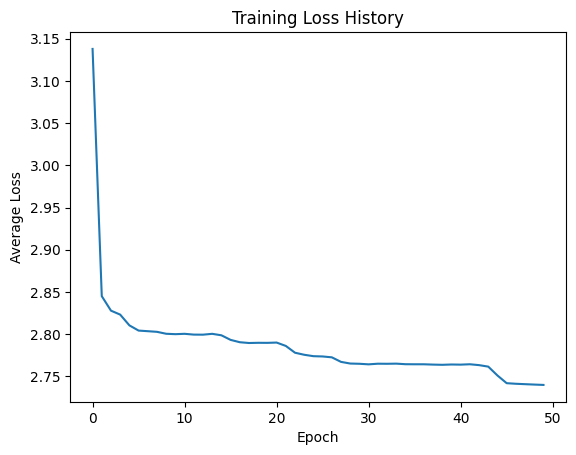

In [29]:
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.plot(epoch_loss)
plt.savefig("DiseasedCNN_9X_TrainingLoss")
plt.show()

### Plot Validation Accuracy

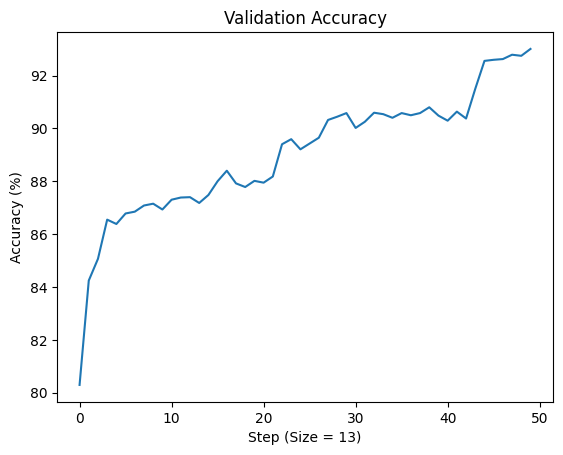

In [30]:
plt.title("Validation Accuracy")
plt.xlabel("Step (Size = 13)")
plt.ylabel("Accuracy (%)")
plt.plot(validation_acc)
plt.savefig("DiseasedCNN_9X_ValAcc")
plt.show()

### Visualize Weights

In [ ]:
# THIS NEEDS TO BE TESTED

bottleneck = model.backbone[-1][1]
conv = bottleneck.conv1
filters = conv.weights

nrow = math.ceil(math.sqrt(filters.shape[0]))
grid = make_grid(filters, nrow=nrow, padding=1, normalize=True, scale_each=True)
plt.imshow(grid.to(device='cpu').permute(1, 2, 0))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Test Model

In [31]:
accuracy = test_model(model=model, test_loader=test_loader, device=DEVICE)
print("Model accuracy: %f" % accuracy)

C:\Users\smitd\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Model accuracy: 93.021300


### Save Full Model

In [ ]:
torch.save(model, 'DiseasedCNN.pth')

### Save Model State Dict

In [32]:
# torch.save(model.state_dict(), 'DiseasedCNN_statedict.pth')
torch.save(model.state_dict(), "extension_model_93.pth")

In [34]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "model_93_optimizer_state.pth")

### Save Training Loss and Validation Accuracy

In [ ]:
file_path = "DiseasedCNN_training_info.pickle"
info = {}
info["epoch_loss"] = epoch_loss
info["validation_acc"] = validation_acc
with open(file_path, "wb") as file:
    pickle.dump(info, file)

TypeError: unhashable type: 'list'